**Version: 1.0.1**

If you encounter any errors, please contact me. I will complete the verification and make corrections as soon as possible.

# Usage Guide

This code consists of three sections: AutoML, Interpretability Analysis, and Exploratory Factor Analysis (EFA).
When using this code, please remember to cite this article. 
Each section includes detailed comments, so please modify the respective variables according to the comments to complete your research.

0. **Preoaration**
1. **AutoML**: Utilize AutoML tools for model training and optimization.
2. **Interpretability Analysis**: Use tools like SHAP for model interpretability analysis to identify important features and their relationships.
3. **Exploratory Factor Analysis (EFA)**: Conduct EFA to uncover the underlying factor structure in the data.

Please adjust the respective variables and parameters according to your specific needs to fit your research data and objectives.


# 0 Preparation

In this section, you need to import the necessary libraries for the code to function correctly. Ensure that each library is successfully imported before proceeding with further steps.

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from autogluon.tabular import TabularDataset, TabularPredictor
from scipy import stats
import shap
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo, Rotator
from sklearn.decomposition import PCA

## 0.1 Data Import
**Feature Engineering**

In this section, you need to import your data and ensure it is converted into a tabular format, with the first row containing the column names. Modify the file path to the CSV file that contains your data.

In [11]:
# Modify the file path to point to your CSV data file
# Load the data into a pandas DataFrame
file_path = '/Users/sunxinru/Desktop/ML/Data/ML_pre.csv'
data=pd.read_csv(file_path,header=0) 
# Display the first few rows of the data to verify successful import
print(data.head())

   selfclarity_1  selfclarity_2  selfclarity_3  selfclarity_4  selfclarity_5  \
0       0.314527      -0.326269       0.760821      -0.859175       0.492151   
1       0.314527       0.458962      -0.906687      -0.032856       0.492151   
2       1.369240       0.458962       0.760821       1.619782       1.322862   
3       0.314527       1.244192       1.594575       0.793463       1.322862   
4      -0.740186      -1.896730      -0.906687      -1.685493      -1.999982   

   selfclarity_6  selfclarity_7  selfclarity_8  selfclarity_9  selfclarity_10  \
0       0.306556       0.413315       0.345348       0.381702       -0.837878   
1       0.306556       0.413315       0.345348      -0.425004        0.764603   
2       0.306556       0.413315       1.145854       1.188408        0.764603   
3       0.306556       1.283179       0.345348       1.188408        1.565844   
4      -1.683093      -0.456549      -1.255664      -1.231711       -0.837878   

   ...  moral_ALT_rt  ability_AL

## 0.2 Data Selection

In psychological research, not all features are necessarily included in the analysis. 
Therefore, after `data.iloc`, input all the variables you wish to include (including the dependent variable). 
Modify the line `target = data['CD-RISC']` by replacing `CD-RISC` with the name of your dependent variable as it appears in your CSV file.

In [4]:
# Modify with the columns you need
#features = data.iloc[:, 1:44]

# Modify 'CD-RISC' to the name of your dependent variable
#target = data['CD-RISC']

#data = pd.concat([features, target], axis=1)
#for column in data.columns:
    #if pd.api.types.is_numeric_dtype(data[column]):
        #data[column] = data[column].astype('float')

In [12]:
# 取出前 140 列作为特征
features = data.iloc[:, 0:140]   # 注意 Python 的列索引是从 0 开始的，所以 0:140 正好是第1-140列

# 取第 141 列作为目标变量（假设列名是 'SGPS'）
target = data.iloc[:, 140]       # 这是第141列

# 合并成新的数据集
data_sgps = pd.concat([features, target], axis=1)

# 确保所有数值列转换为 float 类型
for column in data_sgps.columns:
    if pd.api.types.is_numeric_dtype(data_sgps[column]):
        data_sgps[column] = data_sgps[column].astype('float')

## 0.3 Handling Anomalies
To facilitate checking for anomalies in the data, count the unique values in each column. 
For example, we can see an anomaly in the "Age" column. There is an erroneous value: `Value: 2.0, Count: 1`, where the age was mistakenly entered as 2.
You can follow this example to modify and handle the anomalies in your data. Adjust the variable name and the range according to your needs.

In [13]:
# Count unique values in each column to check for anomalies
for column in data_sgps.columns:
    print(f"Column: {column}")
    value_counts = data_sgps[column].value_counts(dropna=False)
    for value, count in value_counts.items():
        print(f"Value: {value}, Count: {count}")
    print("\n")

Column: selfclarity_1
Value: 0.314526814129491, Count: 254
Value: 1.36924006417705, Count: 90
Value: -0.740186435918068, Count: 80
Value: -1.79489968596563, Count: 77
Value: -2.84961293601319, Count: 2


Column: selfclarity_2
Value: 0.458961839689885, Count: 166
Value: 1.24419247017972, Count: 116
Value: -1.11149942128979, Count: 107
Value: -0.326268790799952, Count: 73
Value: -1.89673005177963, Count: 41


Column: selfclarity_3
Value: -0.906686528943575, Count: 160
Value: 0.760821054451739, Count: 122
Value: -0.0729327372459181, Count: 110
Value: 1.5945748461494, Count: 76
Value: -1.74044032064123, Count: 35


Column: selfclarity_4
Value: -0.859174549653067, Count: 184
Value: 0.793463303025681, Count: 120
Value: -0.0328556233136928, Count: 91
Value: 1.61978222936506, Count: 75
Value: -1.68549347599244, Count: 33


Column: selfclarity_5
Value: 0.492150779997121, Count: 176
Value: -1.1692709806643, Count: 115
Value: 1.32286166032783, Count: 101
Value: -0.33856010033359, Count: 82
Value:

In [5]:
#To address anomalies, replace values in the "Age" column that are less than 18 or greater than 24 with null values.
#data.loc[(data['Age'] < 18) | (data['Age'] > 24), 'Age'] = np.nan

In [14]:
# View Missing Value Proportions
null_ratio = data_sgps.isnull().mean()
print(null_ratio)

selfclarity_1      0.0
selfclarity_2      0.0
selfclarity_3      0.0
selfclarity_4      0.0
selfclarity_5      0.0
                  ... 
ability_SRET_EW    0.0
moral_SRET_EW      0.0
ability_SRET_rt    0.0
moral_SRET_rt      0.0
SGPS               0.0
Length: 141, dtype: float64


In [15]:
# Filling Missing Values with Mean
# data.fillna(data.mean(), inplace=True)
# Filling Missing Values with Median
# data.fillna(data.median(), inplace=True)
# Filling Missing Values with Mode
data.fillna(data_sgps.mode().iloc[0], inplace=True)

## 0.4 Data Standardization or Normalization

In this section, you will standardize or normalize the selected columns in your dataset. 
Standardization transforms the data to have a mean of 0 and a standard deviation of 1. 
Normalization scales the data to a range between 0 and 1.

In [8]:
# Extract the columns to be standardized
#columns_to_scale = ['Age'] + list(data.columns[6:43])
# Initialize the StandardScaler
#scaler = StandardScaler()
#data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])
# Initialize the MinMaxScaler
# min_max_scaler = MinMaxScaler()
# data[columns_to_scale] = min_max_scaler.fit_transform(data[columns_to_scale])

In [16]:
# 拆分数据
features_1_140 = data_sgps.iloc[:, 0:140]      # 前 140 列（已标准化）
features_141_144 = data_sgps.iloc[:, 140:144]  # 第 141–144 列（需要标准化）

# 初始化 StandardScaler
scaler = StandardScaler()

# 标准化 141–144 列
features_141_144_scaled = pd.DataFrame(
    scaler.fit_transform(features_141_144),
    columns=features_141_144.columns,  # 保留原始列名
    index=features_141_144.index
)

# 合并：前 140 列 + 标准化后的 141–144 列
data_sgps = pd.concat([features_1_140, features_141_144_scaled], axis=1)

# 看前几行检查
display(data_sgps.head())

selfclarity_1  selfclarity_2  selfclarity_3  selfclarity_4  selfclarity_5  \
0       0.314527      -0.326269       0.760821      -0.859175       0.492151   
1       0.314527       0.458962      -0.906687      -0.032856       0.492151   
2       1.369240       0.458962       0.760821       1.619782       1.322862   
3       0.314527       1.244192       1.594575       0.793463       1.322862   
4      -0.740186      -1.896730      -0.906687      -1.685493      -1.999982   

   selfclarity_6  selfclarity_7  selfclarity_8  selfclarity_9  selfclarity_10  \
0       0.306556       0.413315       0.345348       0.381702       -0.837878   
1       0.306556       0.413315       0.345348      -0.425004        0.764603   
2       0.306556       0.413315       1.145854       1.188408        0.764603   
3       0.306556       1.283179       0.345348       1.188408        1.565844   
4      -1.683093      -0.456549      -1.255664      -1.231711       -0.837878   

   ...    Social     Moral  ability_ALT_rt  moral_ALT_rt  ability_ALT_d  \
0  ... -0.394679  0.439821        0.375255     -1.109253       1.185451   
1  ...  0.813375 -0.111875       -1.115250     -0.804771      -0.145036   
2  ...  1.216060  0.991517        1.265446     -0.964879       1.332234   
3  ...  1.216060  1.543214        0.110588     -0.655354      -0.189948   
4  ... -1.602734  0.991517       -0.726022      0.365202       0.624957   

   ability_SRET_EW  moral_SRET_EW  ability_SRET_rt  moral_SRET_rt      SGPS  
0         0.764175       0.648044        -0.144987      -0.215157 -0.940081  
1         0.764175       0.214579         0.519029      -1.253541 -0.723669  
2         1.038928       0.214579        -4.720479      -2.142863 -0.182638  
3        -0.060085      -1.085819        -0.331964       0.082375 -1.372906  
4        -0.884345       0.648044         0.384222       0.534325 -1.372906  

[5 rows x 141 columns]

## 0.5 Encoding Categorical Variables

Psychological research often involves many categorical variables. We can handle these by applying one-hot encoding to convert them into a format suitable for machine learning algorithms.

In [ ]:
# List of categorical columns to be encoded
# Replace with your categorical columns
#columns_to_encode = ['Gender','Grade', 'Major', 'Only child', 'Residence']
# Initialize the OneHotEncoder
#encoder = OneHotEncoder(sparse_output=False)
# Fit and transform the categorical features
#encoded_features = encoder.fit_transform(data[columns_to_encode])
# Convert encoded features to a DataFrame
#encoded_columns = encoder.get_feature_names_out(columns_to_encode)
# Reset index to match the original DataFrame
#encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns, index=data.index)

# Drop the original categorical columns from the data
#data.drop(columns=columns_to_encode, inplace=True)
#data = pd.concat([data, encoded_df], axis=1)
#data.head()

# 1. AutoML Section

In this section, we will use AutoML tools to train and optimize machine learning models. AutoML simplifies the process of model selection, hyperparameter tuning, and performance evaluation.

This section will guide you through splitting your data, training a machine learning model using AutoGluon, and evaluating its performance on the test set. AutoGluon handles many of the complexities of model training and tuning, making it easier to achieve high-quality results with minimal effort. Adjust the split ratio (frac=0.8) and the evaluation metric (eval_metric='accuracy') based on your specific needs.

In [17]:
# Load Data
data_sgps = TabularDataset(data_sgps)

In [ ]:
# Split data into training and testing sets
#train_data = data.sample(frac=0.8, random_state=42)  # 80% for training, adjust frac as needed
#test_data = data.drop(train_data.index)  # 20% for testing
#train_data.head()
#label = 'CD-RISC'
#train_data[label].describe()


In [18]:
# 按 80/20 拆分训练集和测试集
train_data = data_sgps.sample(frac=0.8, random_state=42)
test_data = data_sgps.drop(train_data.index)

# 目标变量名称
label = 'SGPS'  

# 查看训练集前几行
print(train_data.head())

# 检查目标变量的分布情况
print(train_data[label].describe())

     selfclarity_1  selfclarity_2  selfclarity_3  selfclarity_4  \
268       0.314527       0.458962       0.760821      -0.032856   
73        0.314527      -0.326269       1.594575      -0.032856   
289       1.369240       0.458962      -0.072933       0.793463   
155      -1.794900      -1.896730      -0.906687      -0.859175   
104       0.314527       1.244192       1.594575       0.793463   

     selfclarity_5  selfclarity_6  selfclarity_7  selfclarity_8  \
268       0.492151       0.306556      -0.456549       0.345348   
73       -1.169271       0.306556       0.413315      -0.455158   
289       0.492151       0.306556       0.413315       0.345348   
155      -1.999982      -1.683093      -1.326413      -2.056170   
104       1.322862       0.306556       1.283179       1.145854   

     selfclarity_9  selfclarity_10  ...    Social     Moral  ability_ALT_rt  \
268      -0.425004       -0.837878  ...  0.813375 -0.111875        0.055784   
73       -1.231711        1.565844  

## 1.1 Training the Model
Use AutoGluon to train a model on the training data. Adjust the evaluation metric (eval_metric) as needed, such as f1, recall, roc_auc, etc.

In [ ]:
# Training the Model.Use AutoGluon to train a model on the training data.
#presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
#presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
#presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
#presets='medium_quality' : Fast training time, ideal for initial prototyping.
#save_path = 'agModels-predictClass'
# Train the model using AutoGluon
#predictor = TabularPredictor(label='CD-RISC').fit(train_data, presets='best_quality',auto_stack=True)
# Display a summary of the training process
#predictor.fit_summary()

In [20]:
# 保存模型的路径
save_path = 'agModels-predictSGPS'

# 目标变量
label = 'SGPS'

# 训练 AutoGluon 模型
predictor = TabularPredictor(
    label=label,
    path=save_path
).fit(
    train_data,
    presets='best_quality',   # 可以改成 high_quality / medium_quality 来平衡速度和准确率
    auto_stack=True
)

# 显示训练过程总结
predictor.fit_summary()

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.7
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:33 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8122
CPU Count:          8
Memory Avail:       3.73 GB / 16.00 GB (23.3%)
Disk Space Avail:   661.61 GB / 926.35 GB (71.4%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. C

(_ray_fit pid=91265) [1000]	valid_set's rmse: 0.978488


(_dystack pid=89349) 	-0.969	 = Validation score   (-root_mean_squared_error)
(_dystack pid=89349) 	3.57s	 = Training   runtime
(_dystack pid=89349) 	0.04s	 = Validation runtime
(_dystack pid=89349) Fitting model: LightGBM_BAG_L2 ... Training model for up to 284.31s of the 284.10s of remaining time.
(_ray_fit pid=91207) No improvement since epoch 24: early stopping [repeated 7x across cluster]
(_dystack pid=89349) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=1.25%)


(_ray_fit pid=91291) [1000]	valid_set's rmse: 0.914142 [repeated 2x across cluster]


(_dystack pid=89349) 	-0.959	 = Validation score   (-root_mean_squared_error)
(_dystack pid=89349) 	3.13s	 = Training   runtime
(_dystack pid=89349) 	0.03s	 = Validation runtime
(_dystack pid=89349) Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 275.46s of the 275.24s of remaining time.
(_dystack pid=89349) 	-1.0162	 = Validation score   (-root_mean_squared_error)
(_dystack pid=89349) 	1.49s	 = Training   runtime
(_dystack pid=89349) 	0.08s	 = Validation runtime
(_dystack pid=89349) Fitting model: CatBoost_BAG_L2 ... Training model for up to 273.86s of the 273.65s of remaining time.
(_dystack pid=89349) 	Memory not enough to fit 8 folds in parallel. Will train 4 folds in parallel instead (Estimated 13.80% memory usage per fold, 55.22%/80.00% total).
(_dystack pid=89349) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (4 workers, per: cpus=2, gpus=0, memory=13.80%)
(_dystack pid=89349) 	-0.986	 = Validation score   (-root_mean_sq

(_ray_fit pid=91601) [1000]	valid_set's rmse: 0.949228
(_ray_fit pid=91597) [1000]	valid_set's rmse: 0.879642


(_dystack pid=89349) 	-0.9647	 = Validation score   (-root_mean_squared_error)
(_dystack pid=89349) 	4.81s	 = Training   runtime
(_dystack pid=89349) 	0.06s	 = Validation runtime
(_dystack pid=89349) Fitting model: NeuralNetFastAI_r191_BAG_L2 ... Training model for up to 177.79s of the 177.58s of remaining time.
(_dystack pid=89349) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.10%)
(_ray_fit pid=91628) No improvement since epoch 1: early stopping
(_dystack pid=89349) 	-0.9531	 = Validation score   (-root_mean_squared_error)
(_dystack pid=89349) 	6.33s	 = Training   runtime
(_dystack pid=89349) 	0.09s	 = Validation runtime
(_dystack pid=89349) Fitting model: CatBoost_r9_BAG_L2 ... Training model for up to 167.33s of the 167.12s of remaining time.
(_dystack pid=89349) 	Memory not enough to fit 8 folds in parallel. Will train 2 folds in parallel instead (Estimated 25.12% memory usage per fold, 50.23%/80.00%

(_ray_fit pid=91886) [1000]	valid_set's rmse: 1.00283 [repeated 6x across cluster]


(_dystack pid=89349) 	-0.9791	 = Validation score   (-root_mean_squared_error)
(_dystack pid=89349) 	4.01s	 = Training   runtime
(_dystack pid=89349) 	0.03s	 = Validation runtime
(_dystack pid=89349) Fitting model: NeuralNetTorch_r22_BAG_L2 ... Training model for up to 65.15s of the 64.94s of remaining time.
(_dystack pid=89349) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=1, gpus=0, memory=0.06%)
(_dystack pid=89349) 	-1.018	 = Validation score   (-root_mean_squared_error)
(_dystack pid=89349) 	6.62s	 = Training   runtime
(_dystack pid=89349) 	0.17s	 = Validation runtime
(_dystack pid=89349) Fitting model: XGBoost_r33_BAG_L2 ... Training model for up to 54.37s of the 54.15s of remaining time.
(_dystack pid=89349) 	Memory not enough to fit 8 folds in parallel. Will train 4 folds in parallel instead (Estimated 18.43% memory usage per fold, 73.72%/80.00% total).
(_dystack pid=89349) 	Fitting 8 child models (S1F1 - S1F8) | Fit

*** Summary of fit() ***
Estimated performance of each model:
                           model  score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0            WeightedEnsemble_L2  -0.958393  root_mean_squared_error       2.376043   44.017866                0.000358           0.011250            2       True        105
1         NeuralNetFastAI_BAG_L1  -0.973939  root_mean_squared_error       0.085446    6.409727                0.085446           6.409727            1       True          6
2    NeuralNetFastAI_r187_BAG_L1  -0.978870  root_mean_squared_error       0.146329    9.571127                0.146329           9.571127            1       True        100
3     NeuralNetFastAI_r37_BAG_L1  -0.981241  root_mean_squared_error       0.310821   57.927483                0.310821          57.927483            1       True         49
4      NeuralNetFastAI_r4_BAG_L1  -0.983990  root_mean_squared_error

{'model_types': {'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_r177_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'NeuralNetTorch_r79_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBM_r131_BAG_L1': 'StackerEnsembleModel_LGB',
  'NeuralNetFastAI_r191_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'CatBoost_r9_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'LightGBM_r96_BAG_L1': 'StackerEnsembleModel_LGB',
  'NeuralNetTorch_r22_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'XGBoost_r33_BAG_L1': 'S

In [21]:
# Evaluate the model on the test data
predictor.evaluate(test_data)

{'root_mean_squared_error': -1.0053829236998542,
 'mean_squared_error': -1.0107948232672668,
 'mean_absolute_error': -0.8400252949328785,
 'r2': -0.03690467975624623,
 'pearsonr': -0.02146135989113238,
 'median_absolute_error': -0.768138242677155}

In [22]:
# Display the best model
predictor.model_best

'WeightedEnsemble_L2'

In [23]:
# 查看所有模型及其性能指标
leaderboard = predictor.leaderboard(silent=True)
print(leaderboard)

# 查看 WeightedEnsemble_L3 的详细信息（包括子模型和权重）
info = predictor.info()
print(info['model_info']['WeightedEnsemble_L2'])

                           model  score_val              eval_metric  \
0            WeightedEnsemble_L2  -0.958393  root_mean_squared_error   
1         NeuralNetFastAI_BAG_L1  -0.973939  root_mean_squared_error   
2    NeuralNetFastAI_r187_BAG_L1  -0.978870  root_mean_squared_error   
3     NeuralNetFastAI_r37_BAG_L1  -0.981241  root_mean_squared_error   
4      NeuralNetFastAI_r4_BAG_L1  -0.983990  root_mean_squared_error   
..                           ...        ...                      ...   
100    NeuralNetTorch_r30_BAG_L1  -1.046184  root_mean_squared_error   
101    NeuralNetTorch_r22_BAG_L1  -1.049564  root_mean_squared_error   
102    NeuralNetTorch_r76_BAG_L1  -1.062669  root_mean_squared_error   
103    NeuralNetTorch_r19_BAG_L1  -1.079681  root_mean_squared_error   
104   NeuralNetTorch_r197_BAG_L1  -1.091971  root_mean_squared_error   

     pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  \
0         2.376043  44.017866                0.000358      

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

## 1.2 Model Leaderboard

View the leaderboard to see the performance of different models trained by AutoGluon.

In [24]:
# Display the leaderboard for models trained by AutoGluon on the test data
predictor.leaderboard(test_data)

model  score_test  score_val  \
0    NeuralNetFastAI_r138_BAG_L1   -0.989301  -0.987847   
1           LightGBM_r188_BAG_L1   -0.991750  -0.993484   
2             CatBoost_r6_BAG_L1   -0.992014  -0.995826   
3             XGBoost_r49_BAG_L1   -0.992095  -0.997399   
4           CatBoost_r128_BAG_L1   -0.992482  -0.998072   
..                           ...         ...        ...   
100   NeuralNetTorch_r135_BAG_L1   -1.078430  -1.034647   
101    NeuralNetTorch_r71_BAG_L1   -1.078834  -1.034369   
102    NeuralNetTorch_r14_BAG_L1   -1.084519  -1.002801   
103    NeuralNetTorch_r19_BAG_L1   -1.087951  -1.079681   
104   NeuralNetTorch_r197_BAG_L1   -1.094113  -1.091971   

                 eval_metric  pred_time_test  pred_time_val   fit_time  \
0    root_mean_squared_error        0.112950       0.558981  46.000834   
1    root_mean_squared_error        0.018600       0.019064   3.132392   
2    root_mean_squared_error        0.027427       0.215407  32.862623   
3    root_mean_squared_error        0.092784       0.096250   6.437705   
4    root_mean_squared_error        0.044678       0.133491  82.535555   
..                       ...             ...            ...        ...   
100  root_mean_squared_error        0.215859       0.322093  22.051531   
101  root_mean_squared_error        0.161669       2.577400  51.305522   
102  root_mean_squared_error        0.139066       0.209032   6.875139   
103  root_mean_squared_error        0.149716       0.176664   7.446630   
104  root_mean_squared_error        0.133387       0.640673  31.010651   

     pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  \
0                   0.112950                0.558981          46.000834   
1                   0.018600                0.019064           3.132392   
2                   0.027427                0.215407          32.862623   
3                   0.092784                0.096250           6.437705   
4                   0.044678                0.133491          82.535555   
..                       ...                     ...                ...   
100                 0.215859                0.322093          22.051531   
101                 0.161669                2.577400          51.305522   
102                 0.139066                0.209032           6.875139   
103                 0.149716                0.176664           7.446630   
104                 0.133387                0.640673          31.010651   

     stack_level  can_infer  fit_order  
0              1       True         82  
1              1       True         23  
2              1       True         81  
3              1       True         66  
4              1       True         59  
..           ...        ...        ...  
100            1       True         93  
101            1       True         69  
102            1       True         35  
103            1       True        101  
104            1       True         50  

[105 rows x 13 columns]

# 2. Interpretability Analysis

In this section, we will use SHAP (SHapley Additive exPlanations) to perform interpretability analysis on the trained model. This helps to identify important features and understand their impact on the model's predictions.

## 2.1 AutoGluon Wrapper for SHAP

This section defines a wrapper class for the AutoGluon predictor, making it compatible with SHAP for interpretability analysis. This part of the code is adapted from the work of AutoGluon developers.

In [49]:
# Initialize the SHAP environment
#shap.initjs()

#class AutogluonWrapper:
    #def __init__(self, predictor, feature_names):
        #self.ag_model = predictor
        #self.feature_names = feature_names
    
    #def predict(self, X):
        #if isinstance(X, pd.Series):
            #X = X.values.reshape(1,-1)
        #if not isinstance(X, pd.DataFrame):
            #X = pd.DataFrame(X, columns=self.feature_names)
        #return self.ag_model.predict(X)

In [25]:
# 初始化 SHAP 环境
shap.initjs()

# 你的特征列（1-140 列，问卷条目）
feature_names = data.columns[:140].tolist()

# 定义 AutoGluon 的包装器，兼容 SHAP
class AutogluonWrapper:
    def __init__(self, predictor, feature_names):
        self.ag_model = predictor
        self.feature_names = feature_names
    
    def predict(self, X):
        # 保证输入为 DataFrame
        if isinstance(X, pd.Series):
            X = X.values.reshape(1, -1)
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)
        return self.ag_model.predict(X)

# 初始化 wrapper（这里 predictor 是你训练好的 AutoGluon 模型）
wrapper = AutogluonWrapper(predictor, feature_names)

**Using the Training Set vs. Test Set for SHAP Explainer**

When creating a SHAP explainer, you have the option to use either the training set or the test set as the baseline. Using the training set as the baseline ensures that SHAP values are calculated based on the same data that the model was trained on, which helps in interpreting the model's behavior on familiar data and maintaining consistency with model training. However, it may not generalize well to new data and could reflect any biases present in the training data. On the other hand, using the test set as the baseline provides SHAP values that better represent the model's performance on unseen data, offering a less biased and more generalizable evaluation. It helps in understanding the model's behavior on real-world data but may lack the training context and could risk data leakage if not used properly. Choose the baseline based on your specific goals for interpretability analysis.


In [17]:
# Extract the features (X) and target variable (y)
#X_train = train_data.drop(columns=['CD-RISC'])# Replace with your target variable name
#y_train = train_data['CD-RISC']# Replace with your target variable name
#X_test = test_data.drop(columns=['CD-RISC'])# Replace with your target variable name
#y_test = test_data['CD-RISC']# Replace with your target variable name

In [26]:
# 提取特征（1-140列）和目标变量（SGPS）
X_train = train_data.iloc[:, :140]   # 前140列作为特征
y_train = train_data['SGPS']         # 第一个目标变量

X_test = test_data.iloc[:, :140]
y_test = test_data['SGPS']

In [27]:
def print_accuracy(f):
    print("Root mean squared test error = {0}".format(np.sqrt(np.mean((f(X_test) - y_test)**2))))

In [28]:
label = 'SGPS'
feature_names = X_train.columns
train_data = X_train.copy()
train_data[label] = y_train
val_data = X_test.copy()

display(train_data.head())

selfclarity_1  selfclarity_2  selfclarity_3  selfclarity_4  \
268       0.314527       0.458962       0.760821      -0.032856   
73        0.314527      -0.326269       1.594575      -0.032856   
289       1.369240       0.458962      -0.072933       0.793463   
155      -1.794900      -1.896730      -0.906687      -0.859175   
104       0.314527       1.244192       1.594575       0.793463   

     selfclarity_5  selfclarity_6  selfclarity_7  selfclarity_8  \
268       0.492151       0.306556      -0.456549       0.345348   
73       -1.169271       0.306556       0.413315      -0.455158   
289       0.492151       0.306556       0.413315       0.345348   
155      -1.999982      -1.683093      -1.326413      -2.056170   
104       1.322862       0.306556       1.283179       1.145854   

     selfclarity_9  selfclarity_10  ...    Social     Moral  ability_ALT_rt  \
268      -0.425004       -0.837878  ...  0.813375 -0.111875        0.055784   
73       -1.231711        1.565844  ... -1.200049 -0.111875       -0.118096   
289       0.381702        1.565844  ...  0.813375  0.991517       -0.932334   
155      -1.231711       -1.639118  ... -0.394679 -0.111875       -1.452860   
104       0.381702        1.565844  ...  0.008006 -0.111875       -0.573470   

     moral_ALT_rt  ability_ALT_d  ability_SRET_EW  moral_SRET_EW  \
268      3.472267       0.054921         0.764175       0.214579   
73       2.622722       0.329820        -0.334838       0.648044   
289     -1.688216      -0.912874         0.214668       0.214579   
155      0.191061      -1.841509        -0.060085       0.648044   
104      0.871062       1.175379         0.214668       0.214579   

     ability_SRET_rt  moral_SRET_rt      SGPS  
268         0.100002      -0.091383 -0.182638  
73         -0.444233       0.155568 -0.507257  
289         0.298583      -0.533714  1.332248  
155         0.338730      -0.211289  0.899423  
104        -0.483882      -0.425214  1.115835  

[5 rows x 141 columns]

In [29]:
feature_names = predictor.feature_metadata.get_features()  # AutoGluon 记录的特征
X_train_summary = shap.kmeans(X_train, 10)
print("Baseline feature-values: \n", X_train_summary)

Baseline feature-values: 


In [30]:
ag_wrapper = AutogluonWrapper(predictor, feature_names)
print_accuracy(ag_wrapper.predict)

explainer = shap.KernelExplainer(ag_wrapper.predict, X_train_summary)

Root mean squared test error = 1.0053829236998542


Root mean squared test error = 1.0053829236998542


  0%|          | 0/101 [00:00<?, ?it/s]

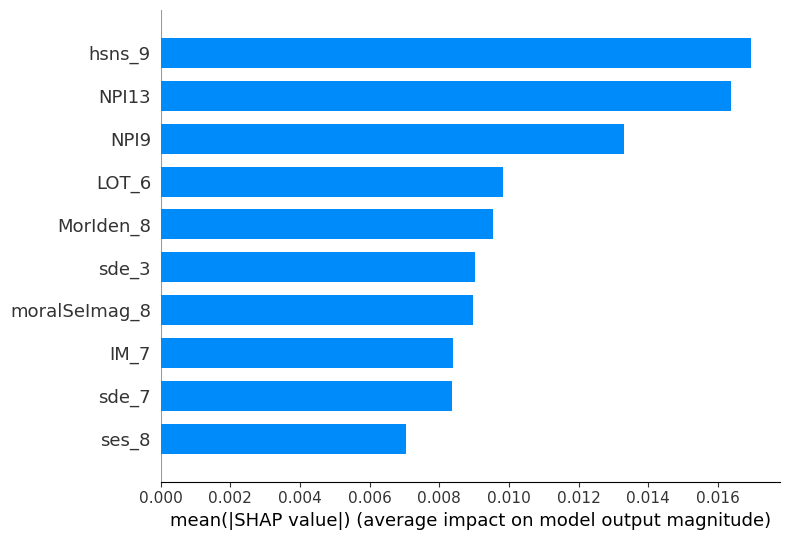

In [31]:
# 1. 设置预测目标
label = 'SGPS'

# 2. 确定特征列（去掉标签）
#feature_names = [col for col in X_train.columns if col not in ['gad', 'phq', 'SWB', label]]

# 3. 构建训练和验证数据
train_data = X_train.copy()
train_data[label] = y_train  # y_train 就是 SGPS

val_data = X_test.copy()

# 4. 初始化 AutogluonWrapper
ag_wrapper = AutogluonWrapper(predictor, feature_names)

# 5. 打印测试集 RMSE（只对 SGPS）
print_accuracy(ag_wrapper.predict)

# 6. 构建 SHAP KernelExplainer
explainer = shap.KernelExplainer(ag_wrapper.predict, X_train_summary)

# 7. 只解释 SGPS 的结果
shap_values = explainer.shap_values(X_test[feature_names])

# 8. 绘制 SHAP 总结图（只显示最重要的特征）
shap.summary_plot(shap_values, X_test[feature_names], plot_type="bar", max_display=10)

In [25]:
ROW_INDEX = 0  # index of an example datapoint
single_datapoint = X_train.iloc[[ROW_INDEX]]
single_prediction = ag_wrapper.predict(single_datapoint)

shap_values_single = explainer.shap_values(single_datapoint)
shap.force_plot(explainer.expected_value, shap_values_single, X_train.iloc[ROW_INDEX,:])

  0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
# Calculate SHAP values for the training data
shap_values = explainer.shap_values(X_train)
shap.force_plot(explainer.expected_value, shap_values,X_train)

  0%|          | 0/402 [00:00<?, ?it/s]

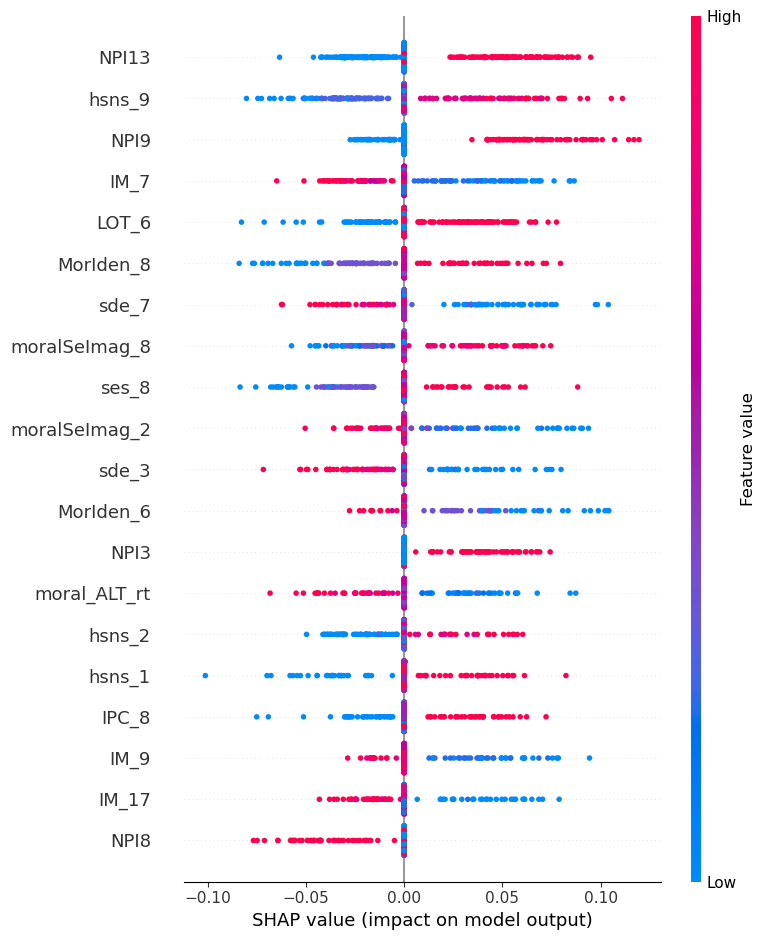

In [27]:
# Generate a SHAP summary plot
shap.summary_plot(shap_values, X_train)

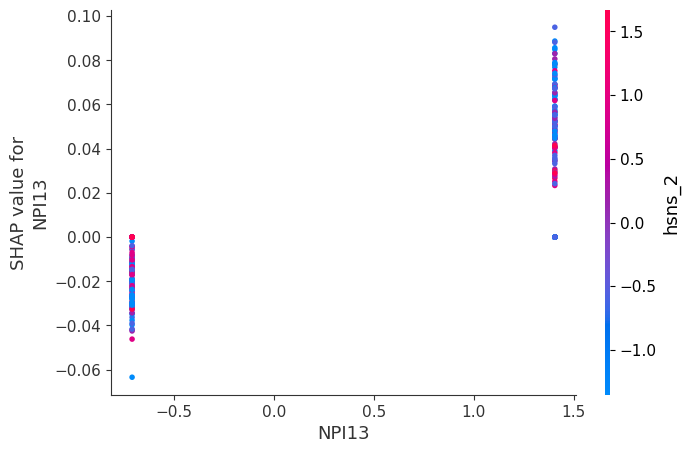

In [28]:
# Generate a SHAP dependence plot for the feature "SES7"
# In this section, we will generate a SHAP dependence plot to visualize the relationship between a specific feature and the model's predictions using the calculated SHAP values.
shap.dependence_plot("NPI13", shap_values,X_train)

# 3. Exploratory Factor Analysis (EFA)

In this section, we will perform Exploratory Factor Analysis (EFA) to uncover the underlying factor structure in the data. EFA helps in identifying the latent variables that explain the patterns in the observed variables.

## 3.1 Preparing Data for EFA

To perform Exploratory Factor Analysis (EFA), we need to calculate the importance of variables and exclude those that do not meet a certain threshold. In this case, we will include variables that contribute up to 80% of the total importance and exclude demographic variables.

In [32]:
# Calculate cumulative importance
shap_values_train = np.array(shap_values)  
feature_importance = np.mean(np.abs(shap_values_train), axis=0)
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)
feature_importance_df['cumulative_importance'] = feature_importance_df['importance'].cumsum()
feature_importance_df['cumulative_importance'] /= feature_importance_df['importance'].sum()

In [33]:
# Determine the number of features to reach 80% importance
threshold = 0.8
num_important_features = (feature_importance_df['cumulative_importance'] <= threshold).sum()
print(f"Number of features to reach {threshold*100}% of importance: {num_important_features}")

Number of features to reach 80.0% of importance: 39


In [34]:
# Printing the Names and Importance of the Top 24 Features
top_features = feature_importance_df.head(num_important_features)
important_feature_names = top_features['feature'].tolist()
print(top_features[['feature', 'importance']])

            feature  importance
67           hsns_9    0.016933
57            NPI13    0.016363
54             NPI9    0.013289
17            LOT_6    0.009832
76        MorIden_8    0.009526
90            sde_3    0.009015
86    moralSeImag_8    0.008954
114            IM_7    0.008381
94            sde_7    0.008355
33            ses_8    0.007029
80    moralSeImag_2    0.006645
124           IM_17    0.005208
51             NPI6    0.005088
25            IPC_8    0.005075
134    moral_ALT_rt    0.004982
60           hsns_2    0.004935
59           hsns_1    0.004927
74        MorIden_6    0.004667
53             NPI8    0.004542
56            NPI11    0.004383
66           hsns_8    0.004165
48             NPI3    0.003896
50             NPI5    0.003582
123           IM_16    0.003470
133  ability_ALT_rt    0.003303
3     selfclarity_4    0.003300
107          sde_20    0.003252
116            IM_9    0.003178
37       coreself_2    0.002920
46             NPI1    0.002743
72      

# Printing the Names and Importance of the Top Features
top_features = feature_importance_df.head(num_important_features)
important_feature_names = top_features['feature'].tolist()
print(top_features[['feature', 'importance']])

In [35]:
# Exclude demographic variables
#variables_to_remove = ['Gender_1.0', 'Gender_2.0','Daily online duration']
#important_feature_names = [feature for feature in important_feature_names if feature not in variables_to_remove]
important_data = data_sgps[important_feature_names]

## 3.2 Parallel Analysis to Determine the Number of Factors

To determine the appropriate number of factors for Exploratory Factor Analysis (EFA), we perform parallel analysis. This method compares the eigenvalues from the actual data with those from randomly generated data.

**Bartlett's Test of Sphericity:** This test assesses whether the correlation matrix is an identity matrix, which would indicate that variables are unrelated. A significant result (p-value < 0.05) suggests that the correlation matrix is not an identity matrix, implying that the data is suitable for factor analysis.

**KMO Test:** The KMO test evaluates the adequacy of the correlation matrix for factor analysis. It measures the proportion of variance among variables that might be common variance. The KMO statistic ranges from 0 to 1, with values closer to 1 indicating that the data is suitable for factor analysis.


In [36]:
def calculate_rmsea(chi_square, dof, n):
    rmsea = np.sqrt((chi_square - dof) / (dof * (n - 1)))
    return rmsea

def calculate_tli(chi_square, dof, chi_square_null, dof_null):
    tli = 1 - (chi_square / dof) / (chi_square_null / dof_null)
    return tli

# Bartlett's Test of Sphericity
# To ensure that the variables are sufficiently correlated for factor analysis, we perform Bartlett's Test of Sphericity. This test checks whether the correlation matrix is significantly different from an identity matrix.
bartlett_test, p_value = calculate_bartlett_sphericity(important_data)
print(f"Bartlett's Test: Chi-square = {bartlett_test}, p-value = {p_value}")

# Perform the Kaiser-Meyer-Olkin (KMO) Test
kmo_all, kmo_model = calculate_kmo(important_data)
print(f"KMO Test: {kmo_model}")

Bartlett's Test: Chi-square = 7778.839880047892, p-value = 0.0
KMO Test: 0.8923941867517329


**Parallel Analysis (Simplified Implementation)**

Determines optimal number of factors by comparing eigenvalues from actual data with those derived from random data using PCA, calculating mean random eigenvalues (mean_random_eigenvalues) as a threshold for component retention

In [37]:
def parallel_analysis(data_sgps, n_iterations=1000):
    n_samples, n_features = data_sgps.shape
    random_eigenvalues = np.zeros((n_iterations, n_features))
    for i in range(n_iterations):
        random_data = np.random.normal(size=data_sgps.shape)
        pca = PCA()
        pca.fit(random_data)
        random_eigenvalues[i, :] = pca.explained_variance_
    mean_random_eigenvalues = random_eigenvalues.mean(axis=0)
    return mean_random_eigenvalues

pca = PCA()
pca.fit(important_data)
eigenvalues = pca.explained_variance_
mean_random_eigenvalues = parallel_analysis(important_data)
num_factors = np.sum(eigenvalues > mean_random_eigenvalues)
print(f"Number of factors to retain based on parallel analysis: {num_factors}")

Number of factors to retain based on parallel analysis: 7


In [38]:
# Create the FactorAnalyzer object, specifying the number of factors to retain
fa = FactorAnalyzer(n_factors=num_factors, rotation='varimax')
fa.fit(important_data)

FactorAnalyzer(n_factors=7, rotation='varimax', rotation_kwargs={})

In [39]:
# Get the factor loadings
loadings = fa.loadings_
variable_names = important_data.columns.tolist()
num_factors = loadings.shape[1]
factor_names = [f'Factor{i+1}' for i in range(num_factors)]
factor_loadings_df = pd.DataFrame(loadings, index=variable_names,columns=factor_names)
# Remove loadings with absolute values less than 0.3
factor_loadings_df = factor_loadings_df.where(abs(factor_loadings_df) >= 0.3, '')
print("Factor Loadings: \n", factor_loadings_df)

Factor Loadings: 
                  Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
hsns_9                                                                       
NPI13                                         0.437905                       
NPI9                                                                         
LOT_6                     0.447256                                           
MorIden_8                             0.4497                                 
sde_3                     0.328297    0.3348                                 
moralSeImag_8                                           0.743519             
IM_7             0.30761            0.615342                                 
sde_7                     0.416932  0.318478                                 
ses_8           0.327281  0.393029                                           
moralSeImag_2                                           0.755682             
IM_17                               0.574475 

In [40]:
# 假设你的 DataFrame 变量名是 factor_loadings
factor_loadings_df.to_csv("SGPS_factor_loadings.csv", index=False)

In [41]:
#Evaluation of the Factor Analysis Model
# Sample and variable counts
n = important_data.shape[0]
p = important_data.shape[1]

# Calculate correlation matrix
corr_matrix = np.corrcoef(important_data, rowvar=False)

# Get loadings and uniquenesses
loadings = fa.loadings_
uniquenesses = 1 - np.sum(loadings**2, axis=1)

# Calculate model-implied correlation matrix
model_corr = loadings @ loadings.T
np.fill_diagonal(model_corr, model_corr.diagonal() + uniquenesses)

# Calculate chi-square using maximum likelihood method
log_det_corr = np.log(np.linalg.det(corr_matrix))
log_det_model = np.log(np.linalg.det(model_corr))
trace = np.trace(corr_matrix @ np.linalg.inv(model_corr)) - p
chi_square = (n - 1) * (log_det_model + trace - log_det_corr)

# Calculate degrees of freedom
dof = (p * (p + 1)) / 2 - (p * num_factors + p - (num_factors * (num_factors - 1)) / 2)

# Calculate null model chi-square
diag_corr = np.diag(np.diag(corr_matrix))
log_det_diag = np.log(np.linalg.det(diag_corr))
trace_null = np.trace(corr_matrix @ np.linalg.inv(diag_corr)) - p
chi_square_null = (n - 1) * (log_det_diag + trace_null - log_det_corr)
dof_null = p * (p - 1) / 2

# Calculate RMSEA 
rmsea = np.sqrt(max(0, (chi_square - dof) / (dof * (n - 1))))

# Calculate TLI
tli = ((chi_square_null / dof_null) - (chi_square / dof)) / ((chi_square_null / dof_null) - 1)

print(f"RMSEA: {rmsea:.4f}")
print(f"TLI: {tli:.4f}")
print(f"Chi-square: {chi_square:.4f}, df: {dof:.4f}")
print(f"p-value: {1 - stats.chi2.cdf(chi_square, dof):.4f}")

RMSEA: 0.0506
TLI: 0.8690
Chi-square: 1116.4294, df: 489.0000
p-value: 0.0000


# # Extra Method 1: R and Python Interaction for Factor Analysis (Recommended)

The code utilizes the rpy2 interface to access R's psych package, preserving R's professional advantages in psychological statistical analysis while incorporating Python's flexibility and data processing capabilities. Users only need to provide appropriately formatted data files, and the system automatically handles R environment configuration, necessary package installation, data conversion, statistical analysis, and results presentation.

The framework supports multiple factor extraction methods and rotation techniques, while providing comprehensive model fit indicators such as RMSEA, TLI, and BIC. This integration delivers a powerful yet user-friendly solution for researchers and practitioners working with psychometric data, combining the best statistical tools from both programming ecosystems.



In [78]:
# Save the Data to CSV File
important_data.to_csv("factor_analysis_data_r.csv", index=False)
print("Factor analysis data successfully exported to factor_analysis_data.csv")

Factor analysis data successfully exported to factor_analysis_data.csv


In [87]:
# Set up R environment
import os
os.environ['R_HOME'] = r'/Library/Frameworks/R.framework/Versions/4.4.1/Resources'  # Use your correct R installation path
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.conversion import localconverter

# Activate pandas to R data conversion
#pandas2ri.activate()
import rpy2.robjects.pandas2ri as pandas2ri
# 读取数据
df = pd.read_csv("/Users/sunxinru/Desktop/ML/Data/ML_pre.csv")

# 在 with 语句里完成 DataFrame -> R data.frame 的转换
#with localconverter(ro.default_converter + pandas2ri.converter):
    #r_df = ro.conversion.py2rpy(df)

def run_parallel_analysis(data_path, fa_method="both", n_iter=100, fm="ml"):
    """
    Run parallel analysis on the data with the specified method.
    
    Parameters:
    -----------
    data_path : str
        Path to the CSV file containing the data.
    fa_method : str
        Method for parallel analysis. Options: "pc", "fa", or "both".
    n_iter : int
        Number of iterations for simulation.
    fm : str
        Factor extraction method. Options: "ml", "minres", "pa", etc.
        
    Returns:
    --------
    dict
        A dictionary containing the analysis results.
    """
    try:
        # Import R base packages
        base = importr('base')
        utils = importr('utils')
        psych = importr('psych')
        
        # Read data
        df = pd.read_csv(data_path)
        print(f"Data successfully loaded: {df.shape[0]} rows and {df.shape[1]} columns")
        
        # Convert data to R dataframe
        with localconverter(ro.default_converter + pandas2ri.converter):
            r_df = ro.conversion.py2rpy(df)
        
        # Execute parallel analysis
        print(f"Starting parallel analysis with method: {fa_method}...")
        ro.r('set.seed(123)')

        r_setup = """
        pdf(file=NULL) 
        """
        ro.r(r_setup)

        # Use R string to execute parallel analysis
        r_code = f"""
        parallel_result <- function(df) {{
          library(psych)
          result <- fa.parallel(df, fa="{fa_method}", fm="{fm}", n.iter={n_iter}, sim=TRUE, show=FALSE)
          dev.off()  
          return(result)
        }}
        """
        ro.r(r_code)
        parallel_result = ro.r('parallel_result')(r_df)
        
        # Extract results based on analysis method
        result = {}
        
        if fa_method in ["fa", "both"]:
            n_factors = parallel_result.rx2('nfact')[0]
            result["n_factors"] = n_factors
            print(f"Suggested number of factors: {n_factors}")
        
        if fa_method in ["pc", "both"]:
            n_components = parallel_result.rx2('ncomp')[0]
            result["n_components"] = n_components
            print(f"Suggested number of components: {n_components}")
        
        # Extract relevant eigenvalues based on method
        r_extract_values = f"""
        extract_values <- function(result) {{
          list(
            observed = if("{fa_method}" == "pc") result$pc.values else if("{fa_method}" == "fa") result$fa.values else NULL,
            simulated = if("{fa_method}" == "pc") {{
              if(is.matrix(result$pc.sim)) colMeans(result$pc.sim) else result$pc.simr
            }} else if("{fa_method}" == "fa") {{
              if(is.matrix(result$fa.sim)) colMeans(result$fa.sim) else result$fa.simr
            }} else NULL,
            fa_observed = if("{fa_method}" == "both") result$fa.values else NULL,
            fa_simulated = if("{fa_method}" == "both") {{
              if(is.matrix(result$fa.sim)) colMeans(result$fa.sim) else result$fa.simr
            }} else NULL,
            pc_observed = if("{fa_method}" == "both") result$pc.values else NULL,
            pc_simulated = if("{fa_method}" == "both") {{
              if(is.matrix(result$pc.sim)) colMeans(result$pc.sim) else result$pc.simr
            }} else NULL
          )
        }}
        """
        ro.r(r_extract_values)
        extracted_values = ro.r('extract_values')(parallel_result)
        
        # Convert R values to Python
        with localconverter(ro.default_converter + pandas2ri.converter):
            if fa_method in ["pc", "fa"]:
                observed = ro.conversion.rpy2py(extracted_values.rx2('observed'))
                simulated = ro.conversion.rpy2py(extracted_values.rx2('simulated'))
                result["observed"] = observed
                result["simulated"] = simulated
            elif fa_method == "both":
                fa_observed = ro.conversion.rpy2py(extracted_values.rx2('fa_observed'))
                fa_simulated = ro.conversion.rpy2py(extracted_values.rx2('fa_simulated'))
                pc_observed = ro.conversion.rpy2py(extracted_values.rx2('pc_observed'))
                pc_simulated = ro.conversion.rpy2py(extracted_values.rx2('pc_simulated'))
                result["fa_observed"] = fa_observed
                result["fa_simulated"] = fa_simulated
                result["pc_observed"] = pc_observed
                result["pc_simulated"] = pc_simulated
        
        # Save suggested factor numbers to file
        #with open(f'suggested_factors_{fa_method}.txt', 'w') as f:
        #    if fa_method in ["fa", "both"]:
        #        f.write(f"Suggested number of factors: {n_factors}\n")
        #    if fa_method in ["pc", "both"]:
        #        f.write(f"Suggested number of components: {n_components}")
        
       # print(f"Parallel analysis completed with method '{fa_method}' and results saved to text file.")
        
        return result
    
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Example usage
if __name__ == "__main__":
    # Change this to the desired method: "pc", "fa", or "both"
    analysis_method = "both"
    
    # Run the analysis
    result = run_parallel_analysis("factor_analysis_data_r.csv", 
                                  fa_method=analysis_method,
                                  n_iter=100, 
                                  fm="pa")

ImportError: cannot import name 'pandas2ri' from 'rpy2.robjects' (unknown location)

In [46]:
try:
    # Import R base packages
    base = importr('base')
    utils = importr('utils')
    stats = importr('stats')
    
    # Check and install necessary R packages
    package_names = ['psych', 'lavaan']
    utils.chooseCRANmirror(ind=1)  # Select CRAN mirror
    
    # Check if packages are installed, install if not
    names_to_install = [x for x in package_names if not ro.packages.isinstalled(x)]
    if len(names_to_install) > 0:
        print(f"Installing R packages: {', '.join(names_to_install)}")
        utils.install_packages(StrVector(names_to_install))
    
    # Import required R packages
    psych = importr('psych')
    lavaan = importr('lavaan')
    
    # Read data
    # Assuming your data is stored in a CSV file
    try:
        data_path = "factor_analysis_data.csv"  # Ensure this file exists
        df = pd.read_csv(data_path)
        print(f"Data successfully loaded: {df.shape[0]} rows and {df.shape[1]} columns")
        
        # Convert pandas dataframe to R dataframe
        with localconverter(ro.default_converter + pandas2ri.converter):
            r_df = ro.conversion.py2rpy(df)
        
        # Execute factor analysis
        print("Starting factor analysis...")
        fa_result = psych.fa(r_df, nfactors=5, rotate="varimax")
        
        # Extract results
        # Get fit indices
        rmsea = fa_result.rx2('RMSEA')[0]
        tli = fa_result.rx2('TLI')[0] if 'TLI' in fa_result.names else None
        bic = fa_result.rx2('BIC')[0] if 'BIC' in fa_result.names else None
        chi_square = fa_result.rx2('chi')[0] if 'chi' in fa_result.names else None
        df_value = fa_result.rx2('dof')[0] if 'dof' in fa_result.names else None
        p_value = fa_result.rx2('PVAL')[0] if 'PVAL' in fa_result.names else None
        
        # Create fit indices dataframe
        fit_indices = pd.DataFrame({
            'RMSEA': [rmsea],
            'TLI': [tli],
            'BIC': [bic],
            'chi_square': [chi_square],
            'df': [df_value],
            'p_value': [p_value]
        })
        
        # Get factor loadings
        loadings_r = fa_result.rx2('loadings')
        
        # Convert R matrix to pandas dataframe
        with localconverter(ro.default_converter + pandas2ri.converter):
            loadings_matrix = ro.conversion.rpy2py(loadings_r)
        
        # Create pandas dataframe from R matrix
        column_names = [f"Factor{i+1}" for i in range(loadings_matrix.shape[1])]
        loadings_df = pd.DataFrame(
            loadings_matrix, 
            index=df.columns, 
            columns=column_names
        )
        
        # Save results to CSV files (if needed)
        #fit_indices.to_csv("fit_indices.csv", index=False)
        #loadings_df.to_csv("factor_loadings.csv")
        
        # Display results
        print("\nFit indices:")
        print(fit_indices)
        print("\nFactor loadings:")
        print(loadings_df)
        
    except FileNotFoundError:
        print(f"Error: Data file '{data_path}' not found, please check the file path")
    except Exception as e:
        print(f"Error processing data: {str(e)}")

except ImportError as e:
    print(f"R package import error: {str(e)}")
    print("Please ensure R and required R packages are correctly installed")
except Exception as e:
    print(f"An error occurred: {str(e)}")

R callback write-console: Warning:  
R callback write-console:  failed to download mirrors file (internet routines cannot be loaded); using local file '/Library/Frameworks/R.framework/Resources/doc/CRAN_mirrors.csv'
  


Error: Data file 'factor_analysis_data.csv' not found, please check the file path


### Additional Method 2: Parallel Analysis Package

The parallel-analysis package offers a comprehensive implementation with enhanced functionality.
However, this Python package is published on the test channel. It is recommended to use Additional Method 1 for more refined control.

Based on package: https://test.pypi.org/project/parallel-analysis/

In [56]:
from parallel_analysis import parallel_analysis

# Perform parallel analysis on the data (using both PCA and FA methods)
results = parallel_analysis(
    important_data,
    n_iterations=100,   # Set 100 iterations for more stable results
    percentile=95,      # Use the 95th percentile as the threshold
    random_state=123,   # Set random seed to ensure reproducibility
    fa="both",          # Use both PCA and FA methods for analysis
    fm="pa",            # Use principal axis factor extraction method
)

# Print PCA results
print("=== PCA Parallel Analysis Results ===")
print(f"Number of components suggested to retain: {results['pc']['n_components']}")

# Print FA results
if 'fa' in results:
    print("\n=== FA Parallel Analysis Results ===")
    print(f"Number of factors suggested to retain: {results['fa']['n_components']}")


=== PCA Parallel Analysis Results ===
Number of components suggested to retain: 2

=== FA Parallel Analysis Results ===
Number of factors suggested to retain: 3
